In [1]:
# %% [markdown]
"""
# 🔧 Tuning Estrategia Movimiento de Promedios - v3

## Descripción de la estrategia
Esta estrategia genera señales de cruce entre medias móviles simples SMA 5 y SMA 20:
- Compra ("buy") cuando SMA5 cruza hacia arriba a SMA20
- Venta ("sell") cuando SMA5 cruza hacia abajo a SMA20

### Mejoras implementadas:
- Confirmación al día siguiente (opcional)
- Filtro por volatilidad usando ATR ratio
- Modo `debug` para inspección avanzada

## Parámetros configurables
- `confirmar_al_dia_siguiente`: bool
- `atr_threshold`: float (umbral ATR ratio)
- `debug`: bool (se desactiva en tuning)

## Objetivo del notebook
Explorar combinaciones de parámetros para identificar configuraciones óptimas según un `score` definido por cantidad y balance de señales generadas.
"""

# %%
# Carga de historicos desde ruta_historicos
import os
import pandas as pd
from pathlib import Path

ruta_historicos = Path("D:/trading/data/historic")
parquets = list(ruta_historicos.glob("*.parquet"))
historicos = {}

for archivo in parquets:
    simbolo = archivo.stem
    try:
        df = pd.read_parquet(archivo)
        if "fecha" in df.columns:
            df["fecha"] = pd.to_datetime(df["fecha"])
            historicos[simbolo] = df.sort_values("fecha").reset_index(drop=True)
    except Exception as e:
        print(f"Error al cargar {archivo.name}: {e}")

print(f"Se cargaron {len(historicos)} símbolos.")

# %%
# Definicion del grid de parametros
import itertools

param_grid = {
    "confirmar_al_dia_siguiente": [False, True],
    "atr_threshold": [0.005, 0.008, 0.012]
}

claves = list(param_grid.keys())
combinaciones = list(itertools.product(*param_grid.values()))
print(f"Total de combinaciones a evaluar: {len(combinaciones)}")

# %%
# Funcion de simulacion por combinacion
import sys
sys.path.append("D:/trading")
from my_modules.estrategias.v3 import mov_avg_v3

def simular_combinacion(args):
    combinacion, historicos = args
    params = dict(zip(claves, combinacion))
    params["debug"] = False  # Desactivar debug en tuning

    resultados = []
    for simbolo, df in historicos.items():
        try:
            df_out = mov_avg_v3.generar_senales(df.copy(), **params)
            df_out["simbolo"] = simbolo
            resultados.append(df_out)
        except Exception as e:
            print(f"Error {simbolo}: {e}")

    if not resultados:
        return {"params": params, "score": -999, "n": 0}

    df_all = pd.concat(resultados)
    n_signals = (df_all.signal != "hold").sum()
    buy_ratio = (df_all.signal == "buy").sum() / max(n_signals, 1)
    score = round(n_signals * (1 + buy_ratio), 2)

    return {"params": params, "score": score, "n": n_signals}

Se cargaron 48 símbolos.
Total de combinaciones a evaluar: 6


In [2]:
# Tuning en paralelo usando joblib + tqdm
from joblib import Parallel, delayed
from tqdm import tqdm

def ejecutar_tuning(historicos, combinaciones):
    def safe_simulacion(comb):
        try:
            return simular_combinacion((comb, historicos))
        except Exception as e:
            print(f"Error en combinación {comb}: {e}")
            return {"params": dict(zip(claves, comb)), "score": -999, "n": 0}

    resultados = Parallel(n_jobs=-1, backend="loky")(
        delayed(safe_simulacion)(comb) for comb in tqdm(combinaciones)
    )
    return resultados

# Ejecutar
print("Ejecutando tuning con joblib...")
resultados = ejecutar_tuning(historicos, combinaciones)

Ejecutando tuning con joblib...


100%|███████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 599.56it/s]


In [3]:
# Top combinaciones por score
import pandas as pd

df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values("score", ascending=False).reset_index(drop=True)
df_resultados["params_str"] = df_resultados["params"].astype(str)
df_resultados[["score", "n", "params_str"]].head(10)

,score,n,params_str
0,15853.0,10569,"{'confirmar_al_dia_siguiente': False, 'atr_thr..."
1,15680.0,10449,"{'confirmar_al_dia_siguiente': False, 'atr_thr..."
2,15125.0,10070,"{'confirmar_al_dia_siguiente': True, 'atr_thre..."
3,15027.0,10015,"{'confirmar_al_dia_siguiente': False, 'atr_thr..."
4,14962.0,9956,"{'confirmar_al_dia_siguiente': True, 'atr_thre..."
5,14346.0,9546,"{'confirmar_al_dia_siguiente': True, 'atr_thre..."


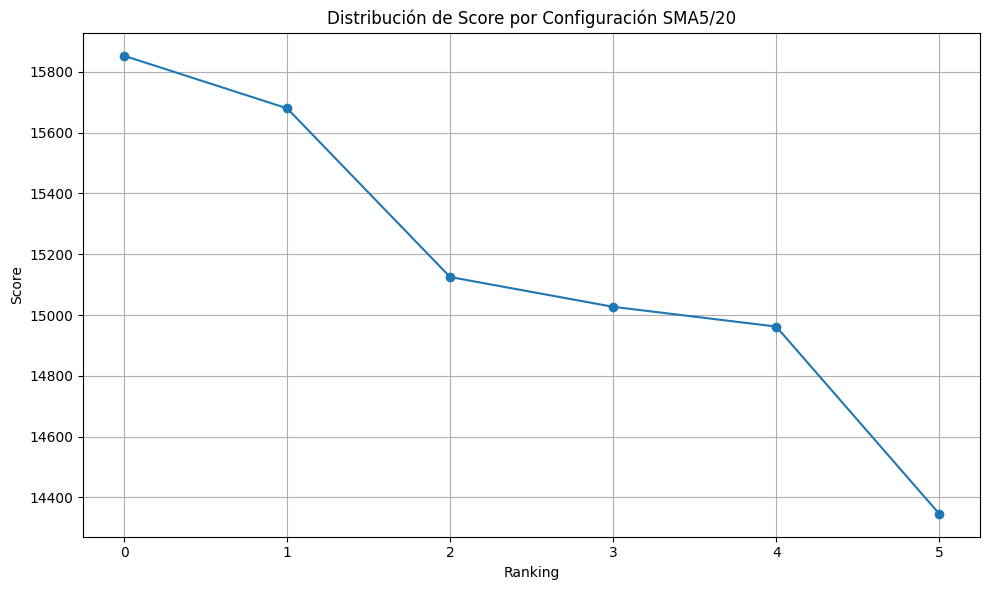

In [4]:
# Visualizacion de resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df_resultados["score"].values, marker="o")
plt.title("Distribución de Score por Configuración SMA5/20")
plt.xlabel("Ranking")
plt.ylabel("Score")
plt.grid(True)
plt.tight_layout()
plt.show()